In [1]:
%matplotlib inline
import numpy
import numpy as np
from matplotlib import pyplot
from amuse.plot import scatter
from amuse.units import (units, constants)
from amuse.ext.orbital_elements import new_binary_from_orbital_elements
from amuse.ext.orbital_elements import orbital_elements_from_binary
from amuse.lab import Particles
from amuse.lab import new_powerlaw_mass_distribution
from amuse.lab import nbody_system
from amuse.community.ph4.interface import ph4
from amuse.ext.LagrangianRadii import LagrangianRadii
def orbital_period(Mtot, a):
    return (((4 * numpy.pi**2) * a**3)/(constants.G * Mtot)).sqrt()

SMBH = Particles(1)
SMBH.name = "SMBH"
SMBH.mass = 4.154e+6 | units.MSun
SMBH.position = (0, 0, 0) | units.pc
SMBH.velocity = (0, 0, 0) | units.kms

In [2]:
def relative_orbital_velocity(distance, mass=SMBH.mass):
    return (constants.G*mass/distance).sqrt()

def dist(body):
    return (body.x**2+body.y**2+body.z**2).sqrt()

def plot(body):
    r = 3
    scatter(body.x.value_in(units.pc), body.y.value_in(units.pc), s=5, alpha=0.5)
    #scatter(SMBH.x.value_in(units.pc), SMBH.z.value_in(units.pc), s=80, c='r')
    pyplot.xlim(-r, r)
    pyplot.ylim(-r, r)
    
def random_p(r_in=0, r_out=3):
    r=r_in + np.random.rand()*(r_out-r_in)
    a=np.random.rand()*2*np.pi
    x=r*np.cos(a) | units.pc
    y=r*np.sin(a) | units.pc
    z = 0 | units.pc
    return x,y,z
    
def random_v(distance):
    r = 3
    v=(np.random.rand()*(2*(constants.G*SMBH.mass/distance-constants.G*SMBH.mass/(r | units.pc)))).sqrt()
    a=np.random.rand()*2*np.pi
    vx=v*np.cos(a)
    vy=v*np.sin(a)
    vz=0 | units.kms
    return vx,vy,vz

/software/amuse/amuse-2021.6/lib/python3.9/site-packages/amuse/units/quantities.py:1161: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return numpy.array(self._number_list, dtype=self.unit.dtype)


Time= 0.0 Myr


KeyboardInterrupt: 

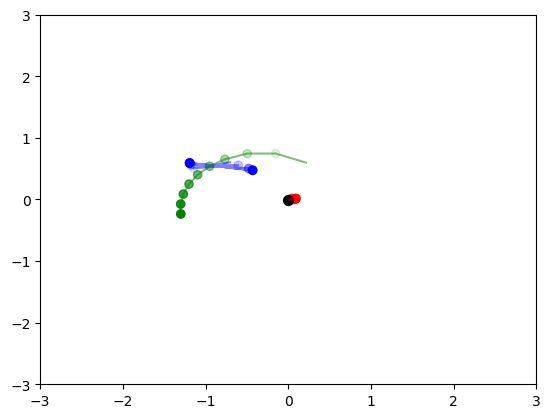

In [3]:
x0 = np.array([])
y0 = np.array([])
x1 = np.array([])
y1 = np.array([])
x3 = np.array([])
y3 = np.array([])
for i in range(0, 1):
    bodies = Particles(2)
    bodies.name = ["BH1", "BH2"]
    bodies.mass = new_powerlaw_mass_distribution(2, 1.0|units.MSun, 100.0|units.MSun, 2.35)
    bodies[0].position = (random_p())
    bodies[1].position = (random_p())
    distance1, distance2 = dist(bodies[0]), dist(bodies[1])
    bodies[0].velocity = (random_v(distance1))
    bodies[1].velocity = (random_v(distance2))
    bodies.add_particles(SMBH)
    
    bodies1 = bodies.copy()
    BH3 = Particles(1)
    BH3.name = "BH3"
    BH3.mass = new_powerlaw_mass_distribution(1, 1.0|units.MSun, 100.0|units.MSun, 2.35)
    BH3.position = (random_p())
    BH3.velocity = (random_v(dist(BH3)))
    bodies1.add_particles(BH3)
    bodies2 = bodies1.copy()
    np.save('bodies_original', bodies2)
    
    converter = nbody_system.nbody_to_si(bodies1.mass.sum(), bodies1.position.length())
#     bodies1.scale_to_standard(converter)
    gravity = ph4(converter, number_of_workers=32)
    gravity.particles.add_particles(bodies1)
    channel = gravity.particles.new_channel_to(bodies1)


    times = numpy.arange(0, 10000, 0.04) | units.Myr
    for time in times:
        gravity.evolve_model(time)
        channel.copy() # Copy from gravity.particles to bodies
        if not time.value_in(units.Myr)%10.0:
            print("Time=", time.in_(units.Myr))
        x0 = np.append(x0, bodies1[0].x.value_in(units.pc))
        y0 = np.append(y0, bodies1[0].y.value_in(units.pc))
        x1 = np.append(x1, bodies1[1].x.value_in(units.pc))
        y1 = np.append(y1, bodies1[1].y.value_in(units.pc))
        x3 = np.append(x3, bodies1[3].x.value_in(units.pc))
        y3 = np.append(y3, bodies1[3].y.value_in(units.pc))
        n_points = 10
        if len(x0)>n_points:
            pyplot.figure()
            pyplot.scatter(x0[-n_points:], y0[-n_points:], color="r", alpha=np.linspace(0,1,n_points))
            pyplot.scatter(x1[-n_points:], y1[-n_points:], color="b", alpha=np.linspace(0,1,n_points))
            pyplot.scatter(x3[-n_points:], y3[-n_points:], color="g", alpha=np.linspace(0,1,n_points))
            pyplot.plot(x0[-n_points:], y0[-n_points:], color="r", alpha=0.5)
            pyplot.plot(x1[-n_points:], y1[-n_points:], color="b", alpha=0.5)
            pyplot.plot(x3[-n_points:], y3[-n_points:], color="g", alpha=0.5)
            pyplot.scatter(bodies1[2].x.value_in(units.pc), bodies1[2].y.value_in(units.pc), s=50, c="k")
            pyplot.xlim(-3, 3)
            pyplot.ylim(-3, 3)
            pyplot.savefig('BH_trace.png')
            pyplot.close()
        b = (bodies1-SMBH).get_binaries()
        if(len(b)>0):
            print("Binary formed at", time)
            break
    
    pyplot.show()

In [7]:
print(bodies1.name)

['BH1' 'BH2' 'SMBH' 'BH3']


In [4]:
print(bodies)
print(bodies1)

                 key         mass         name           vx           vy           vz            x            y            z
                   -         MSun         none  8028481.01748 * m * s**-1  8028481.01748 * m * s**-1          kms       parsec       parsec       parsec
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
 2508999265866466183    6.608e+01          BH1   -3.488e-03   -1.819e-03    0.000e+00   -1.894e+00    2.006e+00    0.000e+00
14557911091842509828    6.101e+01          BH2   -1.329e-04    8.257e-03    0.000e+00    3.542e-01   -1.018e+00    0.000e+00
  528365894453582260    4.154e+06         SMBH    0.000e+00    0.000e+00    0.000e+00    0.000e+00    0.000e+00    0.000e+00
====================  ===========  ===========  ===========  ===========  ===========  ===========  ===========  ===========
                 key         mass         name  potential_in_code       radius     timestep      